### Import packages

In [1]:
import sys
sys.path.insert(0,'../..')
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="2"
import itertools
import matplotlib.pyplot as plt
%matplotlib inline
import torch
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
import torchattacks
import torchvision
from tqdm.auto import tqdm, trange
from torchvision import transforms
from torchattacks.attack import Attack
from torchattacks.attacks._differential_evolution import differential_evolution

### Import biotorch classes and functions

In [2]:
from biotorch.datasets.cifar import CIFAR10Benchmark
from biotorch.applications.adversarial_attacks.visualization import imshow, plot_accuracy
from biotorch.applications.adversarial_attacks.functions import add_data_normalization, apply_attack_on_dataset, apply_attack_on_batch 

In [3]:
dataset = CIFAR10Benchmark(32, test_transforms=[
    transforms.transforms.Resize((32, 32)),
    transforms.ToTensor()])

cifar_mean = (0.4914, 0.4821, 0.4465)
cifar_std = (0.2470, 0.2435, 0.2616)

train_dataloader = dataset.create_train_dataloader(128)
val_dataloader = dataset.create_val_dataloader(128)
test_dataloader = dataset.create_test_dataloader(100)

Preparing CIFAR-10 Benchmark Dataset and storing data in ./datasets/cifar10
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


### Define the models

In [4]:
trained_models_directory = '../trained_models/CIFAR10/resnet-20'

bp_model_path   = os.path.join(trained_models_directory, 'bp/model_best_acc.pth')
fa_model_path   = os.path.join(trained_models_directory, 'fa/model_best_acc.pth')
dfa_model_path  = os.path.join(trained_models_directory, 'dfa/model_best_acc.pth')
sign_usf_model_path = os.path.join(trained_models_directory, 'sign_usf/model_best_acc.pth')
sign_frsf_model_path = os.path.join(trained_models_directory, 'sign_frsf/model_best_acc.pth')
sign_brsf_model_path = os.path.join(trained_models_directory, 'sign_brsf/model_best_acc.pth')

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 

model_bp = torch.load(bp_model_path, map_location='cuda:0')
model_bp = add_data_normalization(model_bp, cifar_mean, cifar_std).eval()
model_bp = model_bp.to(device)

model_fa = torch.load(fa_model_path, map_location='cuda:0')
model_fa = add_data_normalization(model_fa, cifar_mean, cifar_std).eval()
model_fa = model_fa.to(device)

model_dfa = torch.load(dfa_model_path, map_location='cuda:0')
model_dfa = add_data_normalization(model_dfa, cifar_mean, cifar_std).eval()
model_dfa = model_dfa.to(device)

model_sign_usf = torch.load(sign_usf_model_path, map_location='cuda:0')
model_sign_usf = add_data_normalization(model_sign_usf, cifar_mean, cifar_std).eval()
model_sign_usf = model_sign_usf.to(device)

model_sign_frsf = torch.load(sign_frsf_model_path, map_location='cuda:0')
model_sign_frsf = add_data_normalization(model_sign_frsf, cifar_mean, cifar_std).eval()
model_sign_frsf = model_sign_frsf.to(device)

model_sign_brsf = torch.load(sign_brsf_model_path, map_location='cuda:0')
model_sign_brsf = add_data_normalization(model_sign_brsf, cifar_mean, cifar_std).eval()
model_sign_brsf = model_sign_brsf.to(device)

In [6]:
class OnePixel(Attack):
    r"""
    Attack in the paper 'One pixel attack for fooling deep neural networks'
    [https://arxiv.org/abs/1710.08864]
    Modified from "https://github.com/DebangLi/one-pixel-attack-pytorch/" and 
    "https://github.com/sarathknv/adversarial-examples-pytorch/blob/master/one_pixel_attack/"
    Distance Measure : L0
    Arguments:
        model (nn.Module): model to attack.
        pixels (int): number of pixels to change (Default: 1)
        steps (int): number of steps. (Default: 75)
        popsize (int): population size, i.e. the number of candidate agents or "parents" in differential evolution (Default: 400)
        inf_batch (int): maximum batch size during inference (Default: 128)
    Shape:
        - images: :math:`(N, C, H, W)` where `N = number of batches`, `C = number of channels`,        `H = height` and `W = width`. It must have a range [0, 1].
        - labels: :math:`(N)` where each value :math:`y_i` is :math:`0 \leq y_i \leq` `number of labels`.
        - output: :math:`(N, C, H, W)`.
    Examples::
        >>> attack = torchattacks.OnePixel(model, pixels=1, steps=75, popsize=400, inf_batch=128)
        >>> adv_images = attack(images, labels)
    """
    def __init__(self, model, pixels=1, steps=30, popsize=150, inf_batch=128):
        super().__init__("OnePixel", model)
        self.pixels = pixels
        self.steps = steps
        self.popsize = popsize
        self.inf_batch = inf_batch
        self._supported_mode = ['default']

    def forward(self, images, labels):
        r"""
        Overridden.
        """
        images = images.clone().detach().to(self.device)
        labels = labels.clone().detach().to(self.device)

        if self._targeted:
            target_labels = self._get_target_label(images, labels)

        batch_size, channel, height, width = images.shape

        bounds = [(0, height), (0, width)]+[(0, 1)]*channel
        bounds = bounds*self.pixels

        popmul = max(1, int(self.popsize/len(bounds)))

        adv_images = []
        for idx in range(batch_size):
            image, label = images[idx:idx+1], labels[idx:idx+1]

            if self._targeted:
                target_label = target_labels[idx:idx+1]

                def func(delta):
                    return self._loss(image, target_label, delta)

                def callback(delta, convergence):
                    return self._attack_success(image, target_label, delta)

            else:
                def func(delta):
                    return self._loss(image, label, delta)

                def callback(delta, convergence):
                    return self._attack_success(image, label, delta)

            diff_evol = differential_evolution(func=func,
                                           bounds=bounds,
                                           callback=callback,
                                           maxiter=self.steps, popsize=popmul,
                                           init='random',
                                           recombination=1, atol=-1,
                                           polish=False)
            self.diff_evol = diff_evol
            delta = diff_evol.x
            delta = np.split(delta, len(delta)/len(bounds))
            adv_image = self._perturb(image, delta)
            adv_images.append(adv_image)

        adv_images = torch.cat(adv_images)
        return adv_images

    def _loss(self, image, label, delta):
        adv_images = self._perturb(image, delta)  # Mutiple delta
        prob = self._get_prob(adv_images)[:, label]
        if (self._targeted == 1):
            return 1-prob  # If targeted, increase prob
        else:
            return prob  # If non-targeted, decrease prob

    def _attack_success(self, image, label, delta):
        adv_image = self._perturb(image, delta)  # Single delta
        prob = self._get_prob(adv_image)
        pre = np.argmax(prob)
        if (self._targeted == 1) and (pre == label):
            return True
        elif (self._targeted == -1) and (pre != label):
            return True
        return False

    def _get_prob(self, images):
        with torch.no_grad():
            batches = torch.split(images, self.inf_batch)
            outs = []
            for batch in batches:
                out = self.model(batch)
                outs.append(out)
        outs = torch.cat(outs)
        prob = F.softmax(outs, dim=1)
        return prob.detach().cpu().numpy()

    def _perturb(self, image, delta):
        delta = np.array(delta)
        if len(delta.shape) < 2:
            delta = np.array([delta])
        num_delta = len(delta)
        adv_image = image.clone().detach().to(self.device)
        adv_images = torch.cat([adv_image]*num_delta, dim=0)
        for idx in range(num_delta):
            pixel_info = delta[idx].reshape(self.pixels, -1)
            for pixel in pixel_info:
                pos_x, pos_y = pixel[:2]
                channel_v = pixel[2:]
                for channel, v in enumerate(channel_v):
                    adv_images[idx, channel, int(pos_x), int(pos_y)] = v
        return adv_images

In [7]:
def apply_attack_on_limited_dataset(model, dataloader, attack, device, verbose=True, n=1):
    robust_accuracy = []
    c_a = []
    for k, (images, labels) in enumerate(dataloader):
        if k >= n:
            break
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, pre = torch.max(outputs.data, 1)
        correct_predictions = pre == labels
        c_a.append((correct_predictions.sum() / len(correct_predictions)).cpu().numpy())

    clean_accuracy = np.mean(c_a)
    print('Clean accuracy: ', clean_accuracy)

    r_a = []
    if verbose:
        t = trange(len(dataloader))
    for k, (images, labels) in enumerate(dataloader):
        if k >= n:
            break
        images, labels = images.to(device), labels.to(device)
        adv_images = attack(images, labels)
        outputs = model(adv_images)
        _, pre = torch.max(outputs.data, 1)
        correct_predictions = pre == labels
        r_a.append((correct_predictions.sum() / len(correct_predictions)).cpu().numpy())
        if verbose:
            t.update(1)

    robust_acc = np.mean(r_a)
    if verbose:
        print('Robust accuracy: ', robust_acc)
    robust_accuracy.append(robust_acc)

    return clean_accuracy, robust_accuracy

### Run the OnePixel attack

In [8]:
clean_accuracy_bp_list, robust_accuracy_bp_list = [], []
for n_pixel in range(1,6):
    attack_bp = OnePixel(model_bp, pixels=n_pixel)
    clean_accuracy_bp, robust_accuracy_bp = \
            apply_attack_on_limited_dataset(model_bp, test_dataloader, attack_bp, device, verbose=True, n=5)
    clean_accuracy_bp_list.append(clean_accuracy_bp)
    robust_accuracy_bp_list.append(robust_accuracy_bp)

Clean accuracy:  0.91999996


  0%|          | 0/100 [00:00<?, ?it/s]

/home/mohamed/workspace/biotorch/.venv/lib/python3.8/site-packages/torchattacks/attacks/_differential_evolution.py:582: RuntimeWarning: divide by zero encountered in double_scalars
  convergence=self.tol / convergence) is True):


Robust accuracy:  0.596
Clean accuracy:  0.91999996


  0%|          | 0/100 [00:00<?, ?it/s]

Robust accuracy:  0.35799998
Clean accuracy:  0.91999996


  0%|          | 0/100 [00:00<?, ?it/s]

Robust accuracy:  0.324
Clean accuracy:  0.91999996


  0%|          | 0/100 [00:00<?, ?it/s]

Robust accuracy:  0.32
Clean accuracy:  0.91999996


  0%|          | 0/100 [00:00<?, ?it/s]

Robust accuracy:  0.282


In [9]:
clean_accuracy_fa_list, robust_accuracy_fa_list = [], []
for n_pixel in range(1,6):
    attack_fa = OnePixel(model_fa, pixels=n_pixel)
    clean_accuracy_fa, robust_accuracy_fa = \
            apply_attack_on_limited_dataset(model_fa, test_dataloader, attack_fa, device, verbose=True, n=5)
    clean_accuracy_fa_list.append(clean_accuracy_fa)
    robust_accuracy_fa_list.append(robust_accuracy_fa)

Clean accuracy:  0.658


  0%|          | 0/100 [00:00<?, ?it/s]

Robust accuracy:  0.478
Clean accuracy:  0.658


  0%|          | 0/100 [00:00<?, ?it/s]

Robust accuracy:  0.406
Clean accuracy:  0.658


  0%|          | 0/100 [00:00<?, ?it/s]

Robust accuracy:  0.382
Clean accuracy:  0.658


  0%|          | 0/100 [00:00<?, ?it/s]

Robust accuracy:  0.38199997
Clean accuracy:  0.658


  0%|          | 0/100 [00:00<?, ?it/s]

Robust accuracy:  0.37999997


In [10]:
clean_accuracy_dfa_list, robust_accuracy_dfa_list = [], []
for n_pixel in range(1,6):
    attack_dfa = OnePixel(model_dfa, pixels=n_pixel)
    clean_accuracy_dfa, robust_accuracy_dfa = \
            apply_attack_on_limited_dataset(model_dfa, test_dataloader, attack_dfa, device, verbose=True, n=5)
    clean_accuracy_dfa_list.append(clean_accuracy_dfa)
    robust_accuracy_dfa_list.append(robust_accuracy_dfa)

Clean accuracy:  0.542


/home/mohamed/workspace/biotorch/.venv/lib/python3.8/site-packages/torch/nn/modules/module.py:974: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


  0%|          | 0/100 [00:00<?, ?it/s]

Robust accuracy:  0.39200002
Clean accuracy:  0.542


  0%|          | 0/100 [00:00<?, ?it/s]

Robust accuracy:  0.318
Clean accuracy:  0.542


  0%|          | 0/100 [00:00<?, ?it/s]

Robust accuracy:  0.318
Clean accuracy:  0.542


  0%|          | 0/100 [00:00<?, ?it/s]

Robust accuracy:  0.304
Clean accuracy:  0.542


  0%|          | 0/100 [00:00<?, ?it/s]

Robust accuracy:  0.306


In [11]:
clean_accuracy_sign_usf_list, robust_accuracy_sign_usf_list = [], []
for n_pixel in range(1,6):
    attack_sign_usf = OnePixel(model_sign_usf, pixels=n_pixel)
    clean_accuracy_sign_usf, robust_accuracy_sign_usf = \
            apply_attack_on_limited_dataset(model_sign_usf, test_dataloader, attack_sign_usf, device, verbose=True, n=5)
    clean_accuracy_sign_usf_list.append(clean_accuracy_sign_usf)
    robust_accuracy_sign_usf_list.append(robust_accuracy_sign_usf)

Clean accuracy:  0.916


  0%|          | 0/100 [00:00<?, ?it/s]

Robust accuracy:  0.638
Clean accuracy:  0.916


  0%|          | 0/100 [00:00<?, ?it/s]

Robust accuracy:  0.44
Clean accuracy:  0.916


  0%|          | 0/100 [00:00<?, ?it/s]

Robust accuracy:  0.384
Clean accuracy:  0.916


  0%|          | 0/100 [00:00<?, ?it/s]

Robust accuracy:  0.364
Clean accuracy:  0.916


  0%|          | 0/100 [00:00<?, ?it/s]

Robust accuracy:  0.34399998


In [12]:
clean_accuracy_sign_frsf_list, robust_accuracy_sign_frsf_list = [], []
for n_pixel in range(1,6):
    attack_sign_frsf = OnePixel(model_sign_frsf, pixels=n_pixel)
    clean_accuracy_sign_frsf, robust_accuracy_sign_frsf = \
            apply_attack_on_limited_dataset(model_sign_frsf, test_dataloader, attack_sign_frsf, device, verbose=True, n=5)
    clean_accuracy_sign_frsf_list.append(clean_accuracy_sign_frsf)
    robust_accuracy_sign_frsf_list.append(robust_accuracy_sign_frsf)

Clean accuracy:  0.89799994


  0%|          | 0/100 [00:00<?, ?it/s]

Robust accuracy:  0.62600005
Clean accuracy:  0.89799994


  0%|          | 0/100 [00:00<?, ?it/s]

Robust accuracy:  0.42399997
Clean accuracy:  0.89799994


  0%|          | 0/100 [00:00<?, ?it/s]

Robust accuracy:  0.40599996
Clean accuracy:  0.89799994


  0%|          | 0/100 [00:00<?, ?it/s]

Robust accuracy:  0.38599998
Clean accuracy:  0.89799994


  0%|          | 0/100 [00:00<?, ?it/s]

Robust accuracy:  0.354


In [13]:
clean_accuracy_sign_brsf_list, robust_accuracy_sign_brsf_list = [], []
for n_pixel in range(1,6):
    attack_sign_brsf = OnePixel(model_sign_brsf, pixels=n_pixel)
    clean_accuracy_sign_brsf, robust_accuracy_sign_brsf = \
            apply_attack_on_limited_dataset(model_sign_brsf, test_dataloader, attack_sign_brsf, device, verbose=True, n=5)
    clean_accuracy_sign_brsf_list.append(clean_accuracy_sign_brsf)
    robust_accuracy_sign_brsf_list.append(robust_accuracy_sign_brsf)

Clean accuracy:  0.89799994


  0%|          | 0/100 [00:00<?, ?it/s]

Robust accuracy:  0.654
Clean accuracy:  0.89799994


  0%|          | 0/100 [00:00<?, ?it/s]

Robust accuracy:  0.45
Clean accuracy:  0.89799994


  0%|          | 0/100 [00:00<?, ?it/s]

Robust accuracy:  0.42
Clean accuracy:  0.89799994


  0%|          | 0/100 [00:00<?, ?it/s]

Robust accuracy:  0.40399995
Clean accuracy:  0.89799994


  0%|          | 0/100 [00:00<?, ?it/s]

Robust accuracy:  0.38


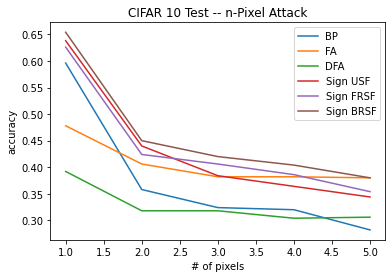

In [14]:
plot_accuracy(list(range(1,6)), 
              [
                  robust_accuracy_bp_list,
                  robust_accuracy_fa_list, 
                  robust_accuracy_dfa_list, 
                  robust_accuracy_sign_usf_list,
                  robust_accuracy_sign_frsf_list,
                  robust_accuracy_sign_brsf_list,
                            ], 
              ['BP', 'FA', 'DFA', 'Sign USF', 'Sign FRSF', 'Sign BRSF'],
              'CIFAR 10 Test -- n-Pixel Attack',
             '# of pixels')

### Run the OnePixel attack on a batch of the test set

In [16]:
images, labels = iter(test_dataloader).next()

In [17]:
adv_images_fa, success_fa, accuracy_clean_fa, accuracy_robust_fa = apply_attack_on_batch(model_fa, images, labels, attack_fa, device)
plot_images_fa = images[success_fa]
plot_images_adv_fa = adv_images_fa[success_fa]

Clean Accuracy on Batch: 0.73%
Robust Accuracy on Batch: 0.4%


In [18]:
adv_images_bp, success_bp, accuracy_clean_bp, accuracy_robust_bp = apply_attack_on_batch(model_bp, images, labels, attack_bp, device)
plot_images_bp = images[success_bp]
plot_images_adv_bp = adv_images_bp[success_bp]

Clean Accuracy on Batch: 0.93%
Robust Accuracy on Batch: 0.29%


In [19]:
adv_images_sign_usf, success_sign_usf, accuracy_clean_sign_usf, accuracy_robust_sign_usf = \
    apply_attack_on_batch(model_sign_usf, images, labels, attack_sign_usf, device)
plot_images_sign_usf = images[success_sign_usf]
plot_images_adv_sign_usf = adv_images_sign_usf[success_sign_usf]

Clean Accuracy on Batch: 0.93%
Robust Accuracy on Batch: 0.34%


In [20]:
adv_images_sign_brsf, success_sign_brsf, accuracy_clean_sign_brsf, accuracy_robust_sign_brsf = \
    apply_attack_on_batch(model_sign_brsf, images, labels, attack_sign_brsf, device)
plot_images_sign_brsf = images[success_sign_brsf]
plot_images_adv_sign_brsf = adv_images_sign_brsf[success_sign_brsf]

Clean Accuracy on Batch: 0.91%
Robust Accuracy on Batch: 0.36%


In [21]:
adv_images_sign_frsf, success_sign_frsf, accuracy_clean_sign_frsf, accuracy_robust_sign_frsf = \
    apply_attack_on_batch(model_sign_frsf, images, labels, attack_sign_frsf, device)
plot_images_sign_frsf = images[success_sign_frsf]
plot_images_adv_sign_frsf = adv_images_sign_frsf[success_sign_frsf]

Clean Accuracy on Batch: 0.9%
Robust Accuracy on Batch: 0.37%


In [22]:
adv_images_dfa, success_dfa, accuracy_clean_dfa, accuracy_robust_dfa = apply_attack_on_batch(model_dfa, images, labels, attack_dfa, device)
plot_images_dfa = images[success_dfa]
plot_images_adv_dfa = adv_images_dfa[success_dfa]

Clean Accuracy on Batch: 0.56%
Robust Accuracy on Batch: 0.36%


### Plot the adversarial images

#### BP

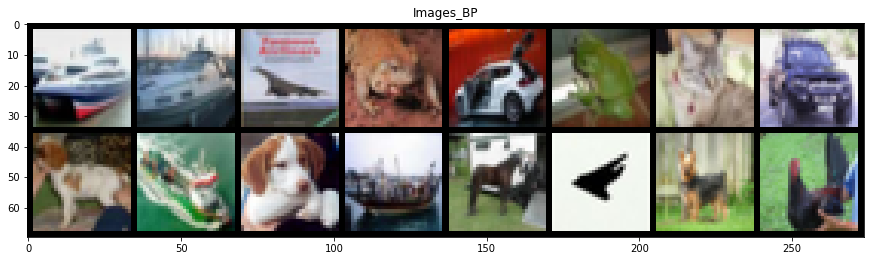

In [23]:
imshow(torchvision.utils.make_grid(plot_images_bp[0:16], normalize=False), "Images_BP")

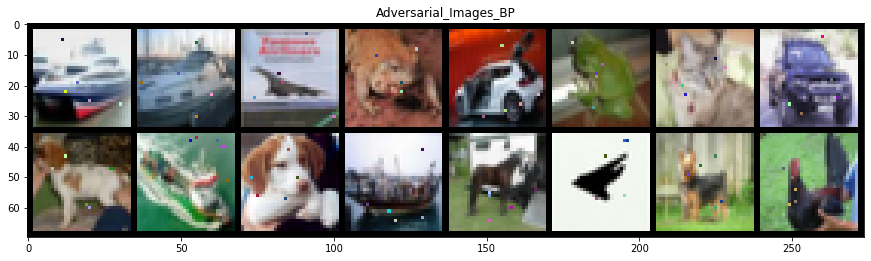

In [24]:
imshow(torchvision.utils.make_grid(plot_images_adv_bp[0:16], normalize=False), "Adversarial_Images_BP")

#### FA

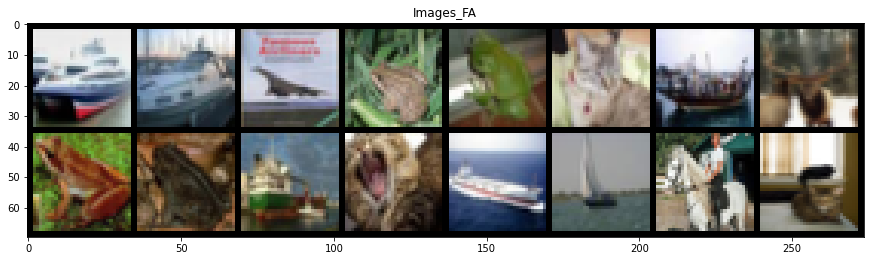

In [25]:
imshow(torchvision.utils.make_grid(plot_images_fa[0:16], normalize=False), "Images_FA")

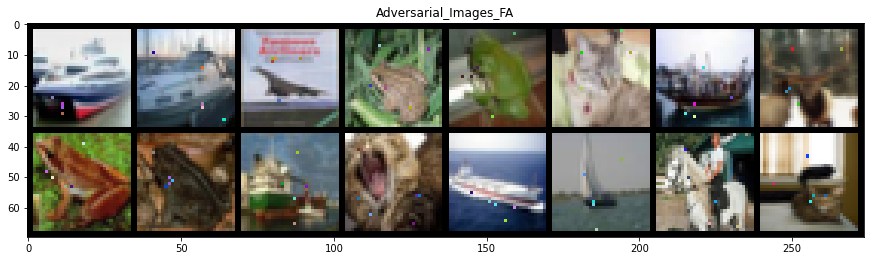

In [26]:
imshow(torchvision.utils.make_grid(plot_images_adv_fa[0:16], normalize=False), "Adversarial_Images_FA")

#### DFA

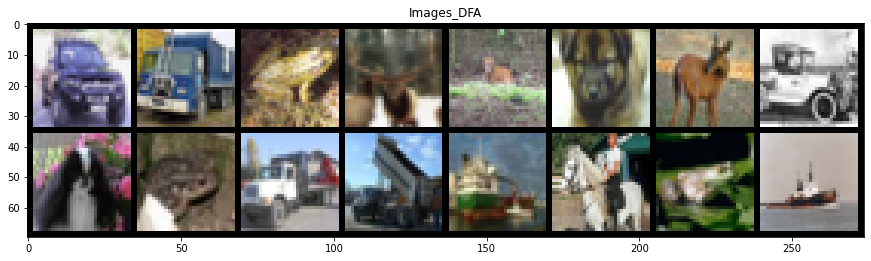

In [27]:
imshow(torchvision.utils.make_grid(plot_images_dfa[0:16], normalize=False), "Images_DFA")

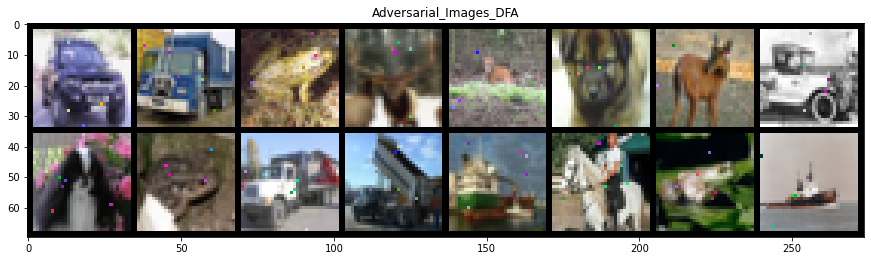

In [28]:
imshow(torchvision.utils.make_grid(plot_images_adv_dfa[0:16], normalize=False), "Adversarial_Images_DFA")

#### Sign USF

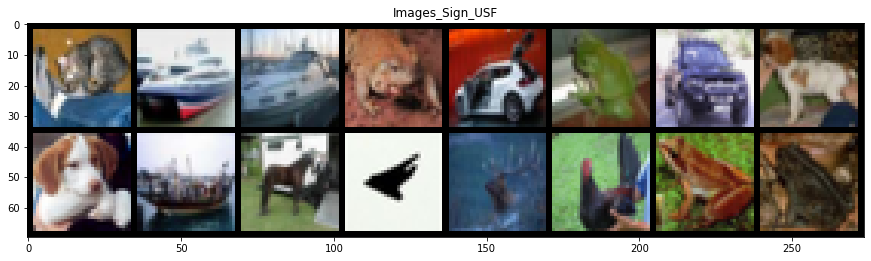

In [29]:
imshow(torchvision.utils.make_grid(plot_images_sign_usf[0:16], normalize=False), "Images_Sign_USF")

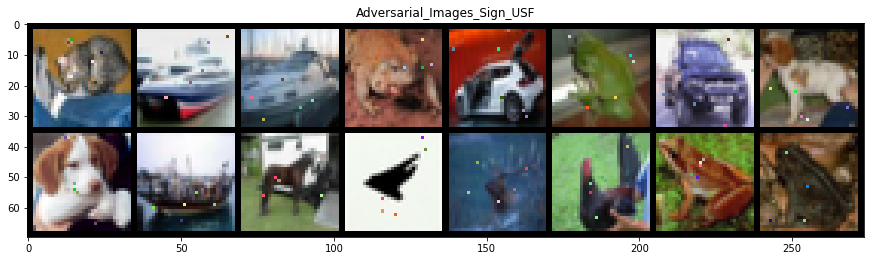

In [30]:
imshow(torchvision.utils.make_grid(plot_images_adv_sign_usf[0:16], normalize=False), "Adversarial_Images_Sign_USF")

#### Sign BRSF

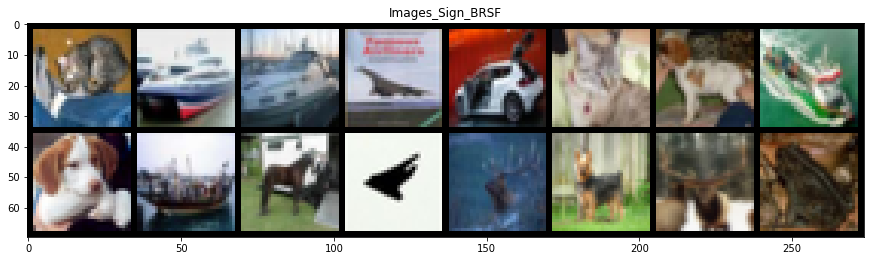

In [31]:
imshow(torchvision.utils.make_grid(plot_images_sign_brsf[0:16], normalize=False), "Images_Sign_BRSF")

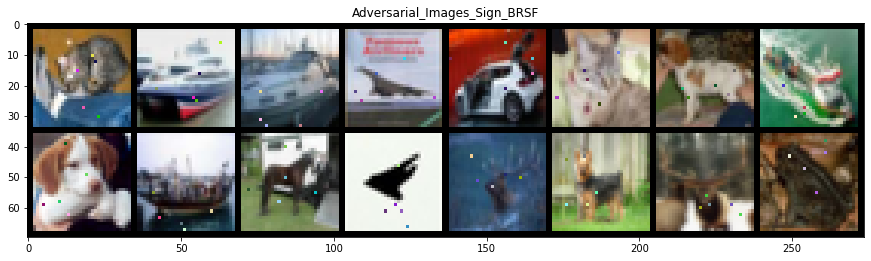

In [32]:
imshow(torchvision.utils.make_grid(plot_images_adv_sign_brsf[0:16], normalize=False), "Adversarial_Images_Sign_BRSF")

#### Sign FRSF

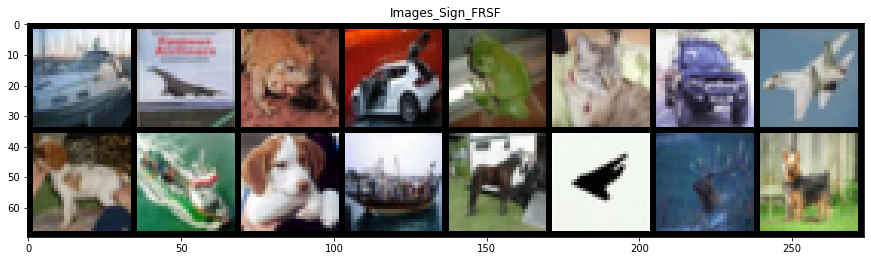

In [33]:
imshow(torchvision.utils.make_grid(plot_images_sign_frsf[0:16], normalize=False), "Images_Sign_FRSF")

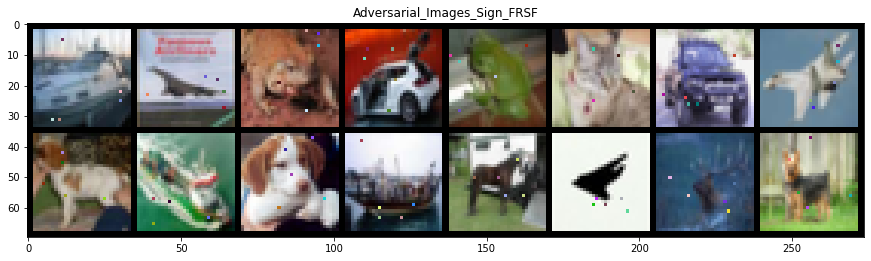

In [34]:
imshow(torchvision.utils.make_grid(plot_images_adv_sign_frsf[0:16], normalize=False), "Adversarial_Images_Sign_FRSF")